In [2]:
from ax import (
    SearchSpace,
    ParameterType,
    ChoiceParameter,
    OptimizationConfig,
    Runner,
    Experiment,
    Objective,
)

import json
from src.agents import NotesAgent, KGAgent, MilvusAgent
from src.agents.notes_agent import BaseNotesResponse

from pydantic import Field
from typing import List
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from src.config import Config

config = Config()

In [3]:
# ---------------------------------- load exp config ----------------------------------
exp_config_path = "/Users/little1d/Desktop/Code/Faithful-BO/src/config/direct_arylation_config.json"
result_dir = "/Users/little1d/Desktop/Code/Faithful-BO/data/notes_result"

with open(exp_config_path, "r") as f:
    da_config = json.load(f)
da_config

{'name': 'Optimization of Direct Arylation Reaction Yield',
 'domain': 'Organic Chemistry - Catalysis',
 'description': 'This experiment aims to optimize reaction conditions for direct arylation to maximize product yield by exploring different bases, ligands, solvents, concentrations, and temperatures.',
 'constraint': 'Reactions must be conducted under inert atmosphere with precise temperature and concentration control.',
 'parameters_and_bounds': [{'name': 'Base_SMILES',
   'description': 'The base used in the reaction, influencing deprotonation efficiency and reaction rate.',
   'bounds': ['O=C([O-])C(C)(C)C.[Cs+]',
    'O=C([O-])C(C)(C)C.[K+]',
    'O=C([O-])C.[Cs+]',
    'O=C([O-])C.[K+]'],
   'type': 'discrete'},
  {'name': 'Ligand_SMILES',
   'description': 'The ligand used to stabilize the catalyst and influence selectivity and yield.',
   'bounds': ['C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1',
    'CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C',
    'CC(C)C1=CC(C(C)C)=C(C(C(C)C)=

In [4]:
# ---------------------------------- Defining custom metric and Notes response ----------------------------------
from typing import Dict


class ExperimentInfoResponse(BaseNotesResponse):
    """Response template for detailed experiment information extraction"""

    reaction_name: str = Field(
        ..., description="Name of the chemical reaction"
    )
    reaction_domain: str = Field(
        ..., description="Chemical domain of the reaction"
    )
    reaction_description: str = Field(
        ..., description="Detailed description of the reaction purpose"
    )
    constraints: List[str] = Field(
        ..., description="Experimental constraints and requirements"
    )
    reactants: List[Dict] = Field(
        ..., description="List of reactants with SMILES and properties"
    )
    conditions: Dict = Field(
        ..., description="Detailed reaction conditions including ranges"
    )
    target: Dict = Field(
        ..., description="Optimization target with description"
    )
    chemical_relationships: List[str] = Field(
        ..., description="Relationships between chemical components"
    )
    theoretical_background: List[str] = Field(
        default_factory=list,
        description="Key theoretical concepts relevant to this reaction",
    )


class ReasoningNotesResponse(BaseNotesResponse):
    """Response format for extracting experiment knowledge from reasoning data"""

    key_findings: List[str] = Field(
        ..., description="Important experimental findings and observations"
    )
    chemical_insights: List[str] = Field(
        ..., description="Chemical insights about the reaction system"
    )
    parameter_relationships: List[str] = Field(
        ...,
        description="Relationships between different experimental parameters",
    )
    optimization_strategies: List[str] = Field(
        ..., description="Suggested optimization approaches"
    )
    theoretical_principles: List[str] = Field(
        ..., description="Underlying chemical principles involved"
    )
    potential_issues: List[str] = Field(
        default_factory=list,
        description="Potential problems or challenges identified",
    )


extract_notes_prompt = """
    Analyze this reasoning data and extract key experiment-related knowledge:
    1. Important findings and observations
    2. Chemical insights about the reaction system
    3. Relationships between different parameters
    4. Suggested optimization strategies
    5. Underlying theoretical principles
    6. Potential issues or challenges
    
    Return structured JSON matching the provided schema.
    Reasoning data: {input}
    """

from src.tasks import ChemistryMetric

In [5]:
# ---------------------------------- Creat Search Space ----------------------------------
parameters = [
    ChoiceParameter(
        name="Base_SMILES",
        parameter_type=ParameterType.STRING,
        values=[
            "O=C([O-])C(C)(C)C.[Cs+]",
            "O=C([O-])C(C)(C)C.[K+]",
            "O=C([O-])C.[Cs+]",
            "O=C([O-])C.[K+]",
        ],
    ),
    ChoiceParameter(
        name="Ligand_SMILES",
        parameter_type=ParameterType.STRING,
        values=[
            "C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1",
            "CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C",
            "CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)=CC=C2OC",
            "CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C)=CC(C(C)C)=C1)C",
            "CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C",
            "CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3",
            "CP(C)C1=CC=CC=C1",
            "CP(C1=CC=CC=C1)C2=CC=CC=C2",
            "FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3C(C)C)C(OC)=CC=C2OC)C4=CC(C(F)(F)F)=CC(C(F)(F)F)=C4)=CC(C(F)(F)F)=C1",
            "P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3",
            "P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3",
            "P(C1CCCCC1)(C2CCCCC2)C3CCCCC3",
        ],
    ),
    ChoiceParameter(
        name="Solvent_SMILES",
        parameter_type=ParameterType.STRING,
        values=[
            "CC(N(C)C)=O",
            "CC1=CC=C(C)C=C1",
            "CCCC#N",
            "CCCCOC(C)=O",
        ],
    ),
    ChoiceParameter(
        name="Concentration",
        parameter_type=ParameterType.FLOAT,
        values=[
            0.057,
            0.1,
            0.153,
        ],
    ),
    ChoiceParameter(
        name="Temp_C", parameter_type=ParameterType.INT, values=[90, 105, 120]
    ),
]

direct_arylation_search_space = SearchSpace(parameters=parameters)

/var/folders/xy/2nl06h6134z8d63822qpjs840000gn/T/ipykernel_64615/1632722945.py:3: AxParameterWarning: `is_ordered` is not specified for `ChoiceParameter` "Base_SMILES". Defaulting to `False`  since the parameter is a string with more than 2 choices.. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction. Note that choice parameters with exactly 2 choices are always considered ordered and that the user-supplied `is_ordered` has no effect in this particular case.
  ChoiceParameter(
/var/folders/xy/2nl06h6134z8d63822qpjs840000gn/T/ipykernel_64615/1632722945.py:3: AxParameterWarning: `sort_values` is not specified for `ChoiceParameter` "Base_SMILES". Defaulting to `False` for parameters of `ParameterType` STRING. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
  ChoiceParameter(
/var/folders/xy/2nl06h6134z8d63822qpjs840000gn/T/ipykernel_64615/1632722945.py:13: AxParameter

In [6]:
# ---------------------------------- Create Optimization Config ----------------------------------
from src.tasks.chemistry.chemistry import ChemistryProblemType

optimization_config = OptimizationConfig(
    objective=Objective(
        metric=ChemistryMetric(
            name="da_faith_bo",
            problem_type=ChemistryProblemType.DIRECT_ARYLATION,
        )
    )
)

In [7]:
# ---------------------------------- Define a Runner ----------------------------------
class DARunner(Runner):
    def run(self, trial):
        trial_metadata = {"name": str(trial.index)}
        return trial_metadata

In [8]:
# ---------------------------------- Create Experiment ----------------------------------

exp = Experiment(
    name="da_faithful_bo",
    search_space=direct_arylation_search_space,
    optimization_config=optimization_config,
    runner=DARunner(),
)

In [9]:
# ---------------------------------- Load Models and NotesAgent ----------------------------------
from src.bo.models import BOModel
from src.bo.reasoner.qwq import QWQReasoner

qwq_reasoner = QWQReasoner(
    exp_config_path=exp_config_path, result_dir=result_dir
)
bo_model = BOModel(exp)

deepseek = ModelFactory.create(
    model_platform=ModelPlatformType.DEEPSEEK,
    api_key=config.DEEPSEEK_API_KEY,
    url=config.DEEPSEEK_API_BASE,
    model_type=ModelType.DEEPSEEK_CHAT,
    model_config_dict={"max_tokens": 2048},
)

kg_agent = KGAgent(deepseek)
milvus_agent = MilvusAgent(collection_name="test")

notes_agent = NotesAgent(
    model=deepseek, kg_agent=kg_agent, milvus_agent=milvus_agent
)

qwq_client = qwq_reasoner.client

Error loading agent_prompts.json: Expecting value: line 1 column 1 (char 0)
Error loading llm_prompts.json: Expecting value: line 1 column 1 (char 0)


In [10]:
# ---------------------------------- 测试实验信息搜索与提取功能 ----------------------------------
experiment_prompt = """
Please extract comprehensive information from this experimental configuration for chemical reaction optimization:

1. Reaction Basics:
   - Name and domain of the reaction
   - Detailed purpose and description
   - Any experimental constraints

2. Chemical Components:
   - List all reactants with their SMILES and properties
   - Extract all possible bases, ligands, and solvents with their SMILES
   - Note any important chemical properties or characteristics

3. Reaction Conditions:
   - Temperature ranges and units
   - Concentration ranges and units
   - Other critical parameters

4. Optimization Target:
   - Target metric name and description
   - Theoretical maximum if available

5. Chemical Relationships:
   - How components interact (e.g., base-deprotonation, ligand-catalyst stabilization)
   - Known effects of condition variations

6. Theoretical Background:
   - Key mechanisms involved
   - Relevant chemical principles
   - Known challenges in this reaction type

Return structured information covering all these aspects. Ensure all SMILES strings are accurate.

Experimental Configuration:
{input}
"""

# 将实验配置(json)转为字符串
experiment_str = json.dumps(da_config, indent=2, ensure_ascii=False)

# 执行提取
print("=== 实验信息提取，并存储至数据库中 ===")
experiment_info = notes_agent.extract_experiment_info(
    experiment_data=experiment_str,
    save_schema=ExperimentInfoResponse,
    prompt=experiment_prompt,
)

In [11]:
# ---------------------------------- 1. 生成 overview ----------------------------------
overview = qwq_reasoner.generate_overview()
print(overview)

Start generating overview...
Overview has been generated! and the content is as follows
 This experiment seeks to optimize reaction conditions for direct arylation to maximize product yield through systematic exploration of bases, ligands, solvents, concentrations, and temperatures. The goal is to identify the most effective combination of these parameters to enhance the reaction's efficiency and yield. The parameters include discrete choices for bases, ligands, and solvents, along with three discrete concentration levels and three temperature points. All reactions must be conducted under inert atmosphere and with precise temperature and concentration control.

Bayesian Optimization (BO) will be employed to efficiently explore the parameter space by iteratively selecting experiments based on predicted yield improvements. BO will start with an initial set of experiments to build a model of the relationship between parameters and yield. As the model improves, BO will suggest more promisi

In [12]:
# 2. 初始采样
comment_first_round = qwq_reasoner.initial_sampling()

Start initial sampling...
Initial sampling process has done! and the comment is as follows
 ```json
{
  "comment": "The initial hypotheses were generated based on known interactions between bases, ligands, solvents, concentrations, and temperatures. The first hypothesis focuses on a strong base and a stabilizing ligand in a polar aprotic solvent at a moderate temperature and concentration. The second hypothesis explores a less basic but still efficient base with a more selective ligand in a protic solvent at a higher temperature and concentration.",
  "keywords": "Bayesian Optimization, Direct Arylation, Reaction Conditions, Yield Optimization",
  "hypotheses": [
    {
      "name": "StrongBaseStableLigand",
      "rationale": "A strong base like Cs+ and a highly stable ligand should enhance deprotonation efficiency and selectivity. The use of a polar aprotic solvent ensures good solubility and reactivity.",
      "confidence": "high",
      "points": [
        {
          "Base_SMILES

In [13]:
# 3. 第一轮实验
candidates_array = qwq_reasoner.optimization_first_round(comment_first_round)
# reasoning data从 qwq_client.messages 里面拿
for msg in qwq_client.messages:
    if msg.get("role") == "think":
        reasoning_data = msg.get("content")
knowledge = notes_agent.extract_notes(
    reasoning_data=reasoning_data,
    save_schema=ReasoningNotesResponse,
    prompt=extract_notes_prompt,
)
print(f"Extracted Notes from reasoning data:{knowledge}")

trial = qwq_reasoner.run_bo_experiment(exp, candidates_array)
qwq_reasoner._save_experiment_data(exp, trial)

Start extracting candidates array from comment...
Done! We have collected candidates less than 5. The candidates points is as follows[{'Base_SMILES': 'O=C([O-])C(C)(C)C.[Cs+]', 'Ligand_SMILES': 'C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1', 'Solvent_SMILES': 'CCCCOC(C)=O', 'Concentration': 0.1, 'Temp_C': 105}, {'Base_SMILES': 'O=C([O-])C(C)(C)C.[K+]', 'Ligand_SMILES': 'CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3', 'Solvent_SMILES': 'CC1=CC=C(C)C=C1', 'Concentration': 0.153, 'Temp_C': 120}]
2025-03-31 15:12:50,177 - camel.agents.chat_agent - ERROR - Failed in parsing the output into JSON: Expecting value: line 1 column 1 (char 0)
Extracted Notes from reasoning data:msgs=[BaseMessage(role_name='Assistant', role_type=<RoleType.ASSISTANT: 'assistant'>, meta_dict={}, content='```json\n{\n  "notes": [],\n  "key_findings": [],\n  "chemical_insights": [],\n  "parameter_relationships": [],\n  "optimization_strategies": [],\n  "theoretical_principles": [],\n  "potential_is

In [ ]:
# 4. 多轮优化循环
num_iterations = 2  # 设置迭代次数
for i in range(num_iterations):
    # TODO
    # 检索的时候要在 comment 中加入 key_word 键，用 key_word 去 query 知识库，放在 optimization_loop 函数中
    # 如果不想启用混合检索，只需要不传 retrieved_context 或置空
    keywords = qwq_reasoner.get_keywords()
    print(f"Keywords:{keywords}")
    retrieved_context = ''
    if keywords:
        results = notes_agent.query_notes(
            query=keywords, top_k=3, similarity_threshold=0.7
        )
        retrieved_context = notes_agent.format_retrieved_notes(results)
    print(f"retrieved context: \n{retrieved_context}")
    candidates_array = qwq_reasoner.optimization_loop(
        experiment=exp,
        trial=trial,
        bo_model=bo_model,
        n=5,
        retrieval_context=retrieved_context,
    )
    # 在这里再从 qwq_client.messages 中拿到 reasoning data 并存储
    for msg in qwq_client.messages:
        if msg.get("role") == "think":
            reasoning_data = msg.get("content")
    knowledge = notes_agent.extract_notes(
        reasoning_data=reasoning_data,
        save_schema=ReasoningNotesResponse,
        prompt=extract_notes_prompt,
    )
    trial = qwq_reasoner.run_bo_experiment(exp, candidates_array)

Keywords:Bayesian Optimization, Direct Arylation, Reaction Conditions, Yield Optimization
Start use bo algorithms to generate bo_recommendations candidates...
Done!



/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo

Start Loading trial data from multiple CSV files as a combined string
Done!

Start concatenating comment jsonl...
Done!

Start Optimization iteration 0...
Optimization loop iteration 0 has done! and the comment is as follows
 {
  "comment": "Based on the initial hypotheses and the data collected, we observed that the combination of potassium carbonate (O=C([O-])C(C)(C)C.[K+]) as a base with a phosphine ligand (CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3) in a protic solvent (CC1=CC=C(C)C=C1) at a moderate temperature (120°C) and concentration (0.153 M) showed promising results, achieving a mean yield of 29.39%. This suggests that the interaction between a moderately basic base and a highly selective ligand in a protic solvent is beneficial for yield. Conversely, the use of a polar aprotic solvent (CCCCOC(C)=O) with a less selective ligand did not yield significant improvements, indicating that the solvent type and ligand selectivity are critical factors. Further exploratio

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/little1d/Desktop/Dev_env/miniconda3/envs/bo/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



Start Loading trial data from multiple CSV files as a combined string
Done!

Start concatenating comment jsonl...
Done!

Start Optimization iteration 1...
Optimization loop iteration 1 has done! and the comment is as follows
 {
  "comment": "From the data, we observe that the use of potassium carbonate (O=C([O-])C(C)(C)C.[K+]) as a base in combination with a phosphine ligand (CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3) in a protic solvent (CC1=CC=C(C)C=C1) at a moderate temperature (120°C) and concentration (0.153 M) achieved a high yield of 29.39%. This indicates that the interaction between a moderately basic base and a highly selective ligand in a protic solvent is beneficial for yield. The use of a polar aprotic solvent (CCCCOC(C)=O) did not yield significant improvements, suggesting that the solvent type and ligand selectivity are critical factors. Further exploration of the concentration and temperature subspaces could lead to better optimization. Based on these ins

In [16]:
# 5. 生成实验分析
qwq_reasoner.generate_experiment_analysis()

Start generating experiment analysis..., conluding overview, experiment summary and conclusion. 

Start Loading trial data from multiple CSV files as a combined string
Done!

Start concatenating comment jsonl...
Done!

Start generating summary...

Experiment summary has been generated! and the comment is as follows
 ### Evolution of Hypotheses

Initially, hypotheses focused on leveraging strong bases and highly selective ligands in polar aprotic solvents. However, experiments revealed that a protic solvent (CC1=CC=C(C)C=C1) with a moderately basic base (K+) and a highly selective ligand (CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3) at moderate temperature (120°C) and concentration (0.153 M) yielded a high mean yield of 29.39%. This indicated the critical role of solvent type and ligand selectivity. Subsequent hypotheses refined this setup by optimizing concentration and temperature, evaluating lower concentrations, and exploring higher temperatures.

### Confidence Evoluti

In [17]:
from src.utils.metric import extract_mean_metric, extract_max_metric

mean_results = extract_mean_metric(exp=exp, metric_name="da_faith_bo")
max_results = extract_max_metric(exp=exp, metric_name="da_faith_bo")

In [18]:
mean_results

array([26.695     , 39.935     , 28.80666667])

In [19]:
max_results

array([29.39, 62.15, 47.33])

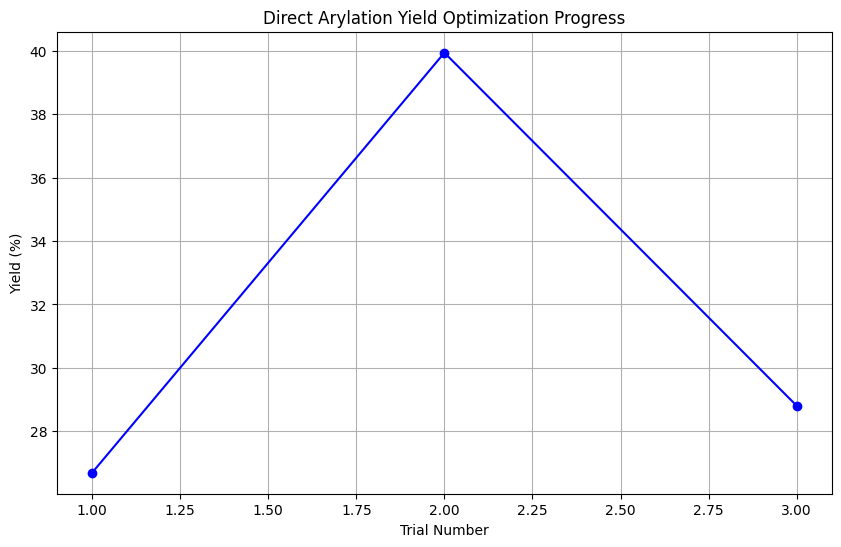

In [20]:
import matplotlib.pyplot as plt

# Create x-axis (trial numbers)
trials = range(1, len(mean_results) + 1)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(trials, mean_results, marker='o', linestyle='-', color='b')
plt.xlabel('Trial Number')
plt.ylabel('Yield (%)')
plt.title('Direct Arylation Yield Optimization Progress')
plt.grid(True)

# Show plot
plt.show()

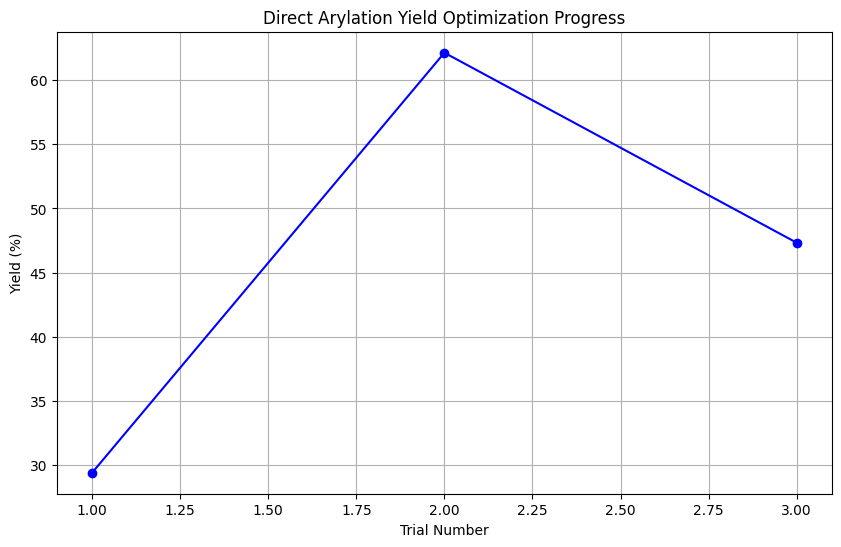

In [21]:
import matplotlib.pyplot as plt

# Create x-axis (trial numbers)
trials = range(1, len(max_results) + 1)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(trials, max_results, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Trial Number')
plt.ylabel('Yield (%)')
plt.title('Direct Arylation Yield Optimization Progress')
plt.grid(True)

# Show plot
plt.show()